In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [4]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [5]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

# Clustering of play data

In [6]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns).drop(['gameId', 'playId'], axis=1)

## K-Means

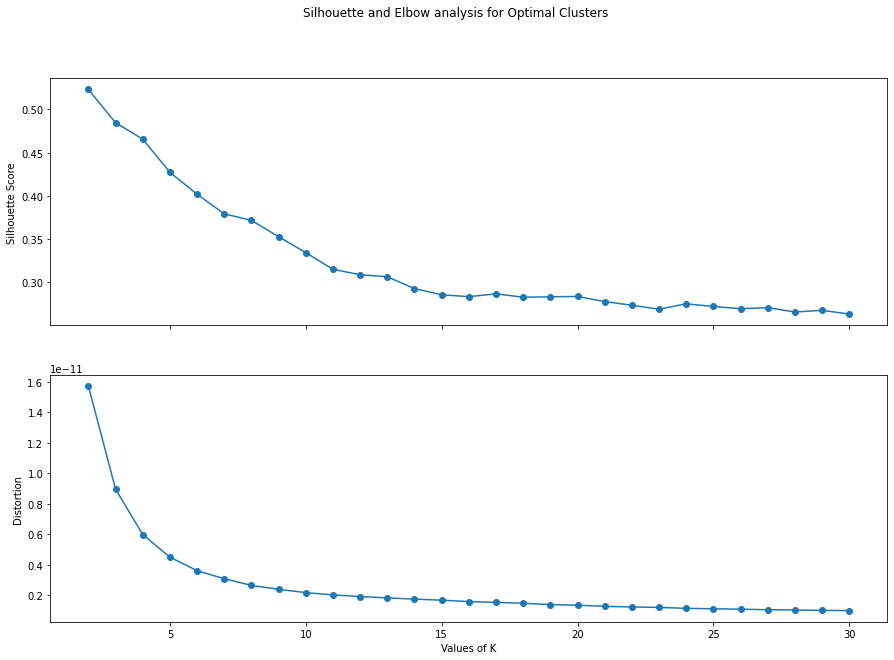

In [61]:
max_clusters = 30

range_clusters = []
for i in range(2, max_clusters + 1):
    range_clusters.append(i)

silhouette_avg = []
distortions = []

for i in range_clusters:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=1
    )
    km.fit(df_scaled)
    cluster_labels = km.labels_

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))
    distortions.append(km.inertia_)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
axs[0].plot(range_clusters, silhouette_avg, marker='o')
#axs[0].set_xlabel('Distance Threshold (x10e-6)')
axs[0].set_ylabel('Silhouette Score')
axs[1].plot(range_clusters, distortions, marker='o')
axs[1].set_xlabel('Values of K')
axs[1].set_ylabel('Distortion')
fig.suptitle('Silhouette and Elbow analysis for Optimal Clusters')
plt.show()

In [62]:
k = 6
km = KMeans(
    n_clusters=k, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=1
)

y_km = km.fit_predict(df_scaled)
df['clusters_kmeans'] = y_km

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

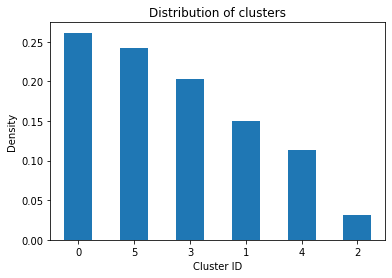

In [63]:
(df['clusters_kmeans'].value_counts()/df['clusters_kmeans'].value_counts().sum()).plot.bar(rot=0, title='Distribution of clusters', xlabel='Cluster ID', ylabel='Density')

## Agglomerative Clustering

### Silhouette testing on number of clusters

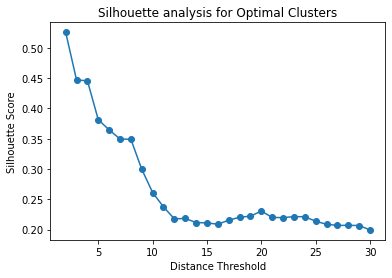

In [64]:
# Silhouette testing on n_clusters
range_clusters = []
n_samples = df_scaled.shape[0]
[range_clusters.append(x) for x in range(2, max_clusters + 1)]
silhouette_avg = []

for i in range_clusters:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=None,
                                n_clusters=i)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_clusters, silhouette_avg, marker='o')
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
plt.show()

### Silhouette testing on distance threshold

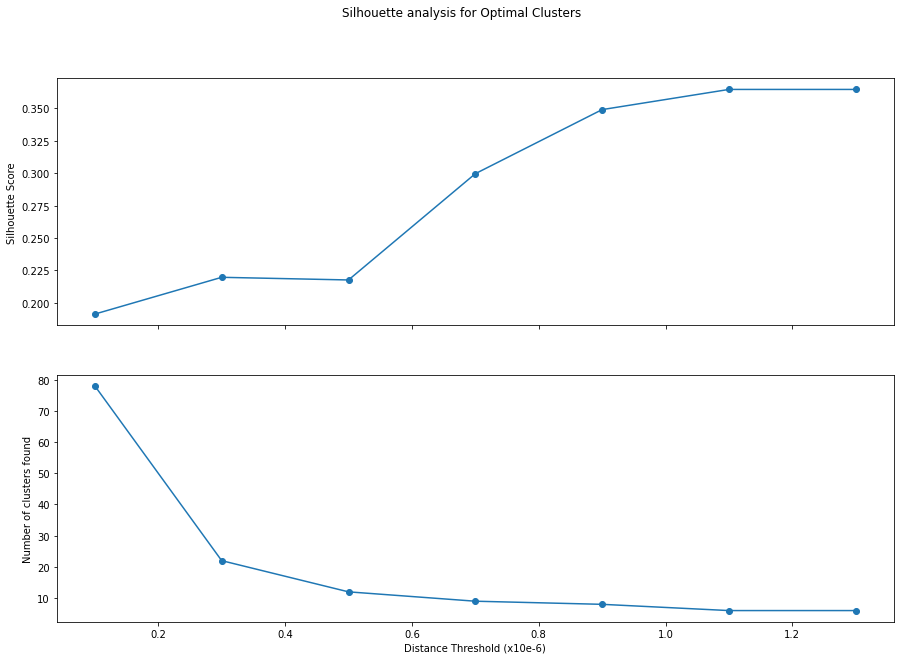

In [65]:
# Silhouette testing on limit
range_limit = [0.0000001, 0.0000003, 0.0000005, 0.0000007, 0.0000009, 0.0000011, 0.0000013]
n_samples = df_scaled.shape[0]

silhouette_avg = []
clusters_found = []

for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    clusters_found.append(np.unique(model.labels_).size)
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))

axs[0].plot(np.array(range_limit) * 10**6, silhouette_avg, marker='o')
#axs[0].set_xlabel('Distance Threshold (x10e-6)')
axs[0].set_ylabel('Silhouette Score')

axs[1].plot(np.array(range_limit) * 10**6, clusters_found, marker='o')
axs[1].set_xlabel('Distance Threshold (x10e-6)')
axs[1].set_ylabel('Number of clusters found')
fig.suptitle('Silhouette analysis for Optimal Clusters')

plt.show()

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

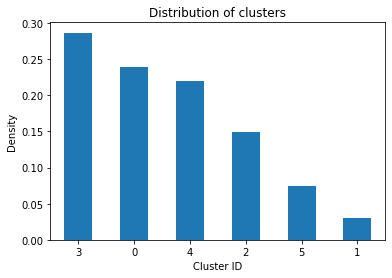

In [66]:
threshold = 1.1 * 10**-6
model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=threshold,
                                n_clusters=None)
model.fit(df_scaled)

df['clusters_agg'] = model.labels_
(df['clusters_agg'].value_counts() / df['clusters_agg'].value_counts().sum()).plot.bar(rot=0,
                                                                                             title='Distribution of clusters',
                                                                                             xlabel='Cluster ID',
                                                                                             ylabel='Density')

## Random Forest

In [68]:
features = df[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']]
cols = ['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']
x_train, x_test, y_train, y_test = train_test_split(df[cols], df[['clusters_kmeans', 'clusters_agg']], test_size=0.4, shuffle=False, random_state=1)

In [69]:
y_train.shape

(3631, 2)

In [70]:
clf_k = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clf_k.fit(x_train, y_train['clusters_kmeans'])

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

In [71]:
clf_a = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clf_a.fit(x_train, y_train['clusters_agg'])

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

In [17]:
clf_a = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clusters_a = df['clusters_agg']
clf_a.fit(features, clusters_a)

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

<BarContainer object of 27 artists>

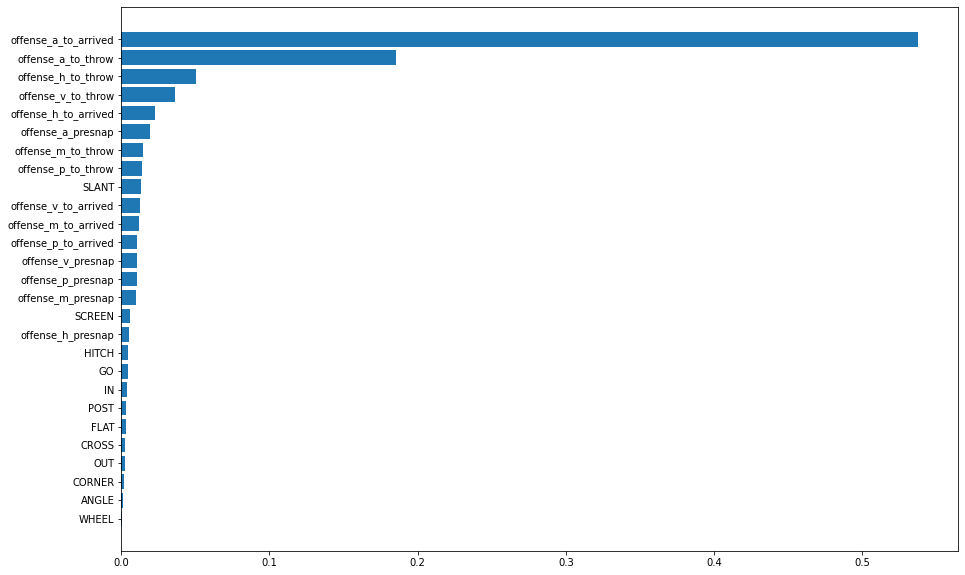

In [72]:
plt.figure(figsize=(15, 10))
sorted_idx_k = clf_k.feature_importances_.argsort()
plt.barh(clf_k.feature_names_in_[sorted_idx_k], clf_k.feature_importances_[sorted_idx_k])

<BarContainer object of 27 artists>

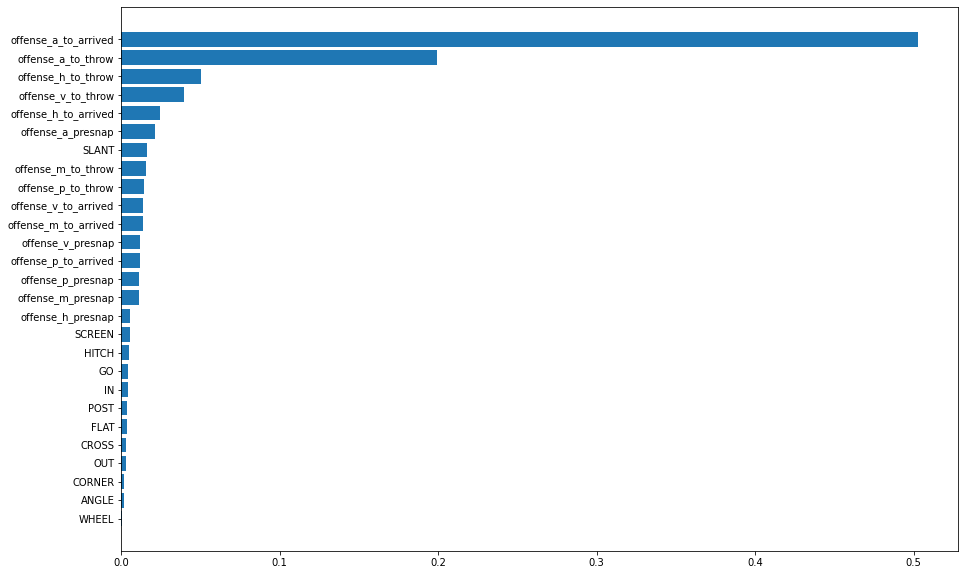

In [73]:
plt.figure(figsize=(15, 10))
sorted_idx_a = clf_a.feature_importances_.argsort()
plt.barh(clf_a.feature_names_in_[sorted_idx_a], clf_a.feature_importances_[sorted_idx_a])

In [74]:
perm_imp_k = permutation_importance(clf_k, x_train, y_train['clusters_kmeans'])

In [75]:
perm_imp_a = permutation_importance(clf_a, x_train, y_train['clusters_agg'])

<BarContainer object of 27 artists>

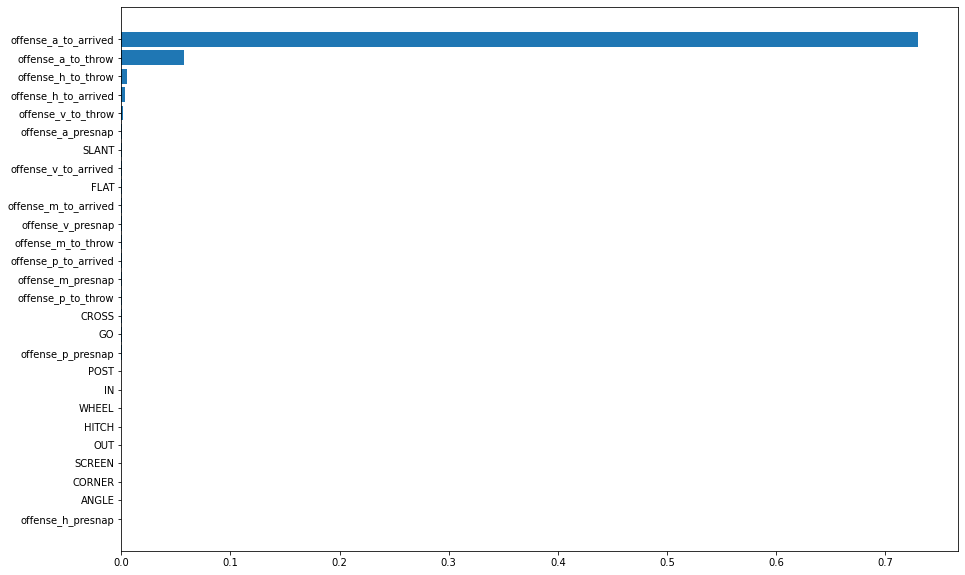

<BarContainer object of 27 artists>

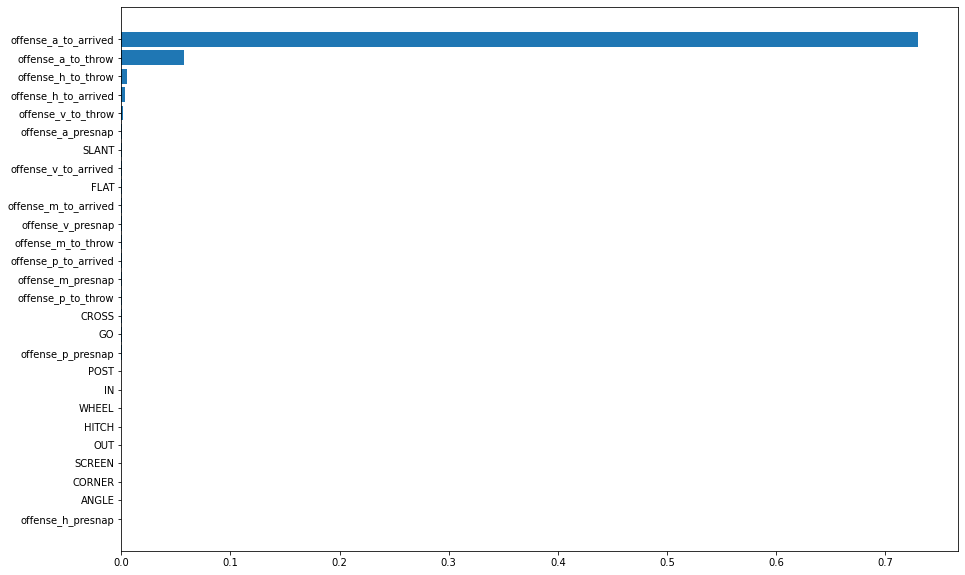

<BarContainer object of 27 artists>

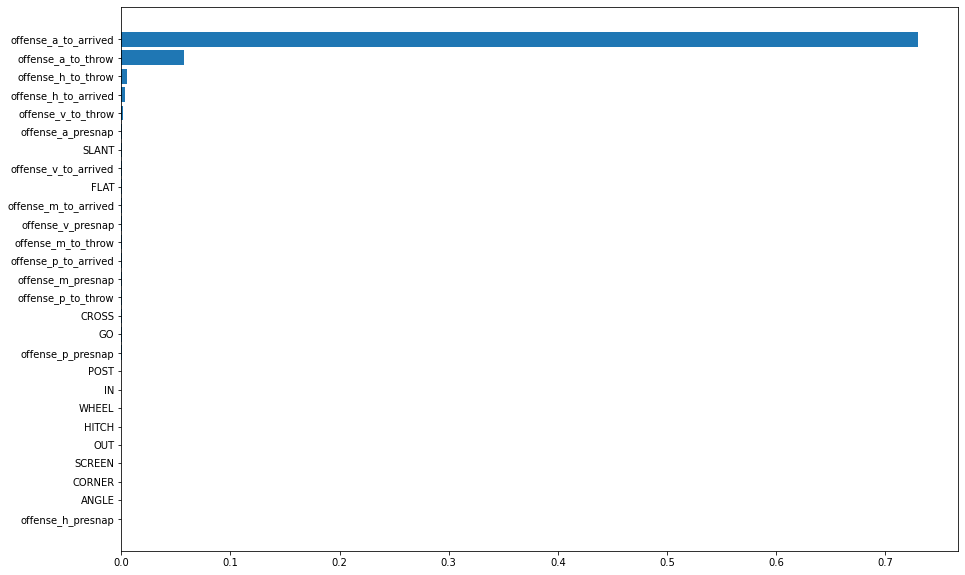

In [78]:
plt.figure(figsize=(15, 10))
sorted_idx_k = perm_imp_k.importances_mean.argsort()
plt.barh(clf_k.feature_names_in_[sorted_idx_k], perm_imp_k.importances_mean[sorted_idx_k])

<BarContainer object of 27 artists>

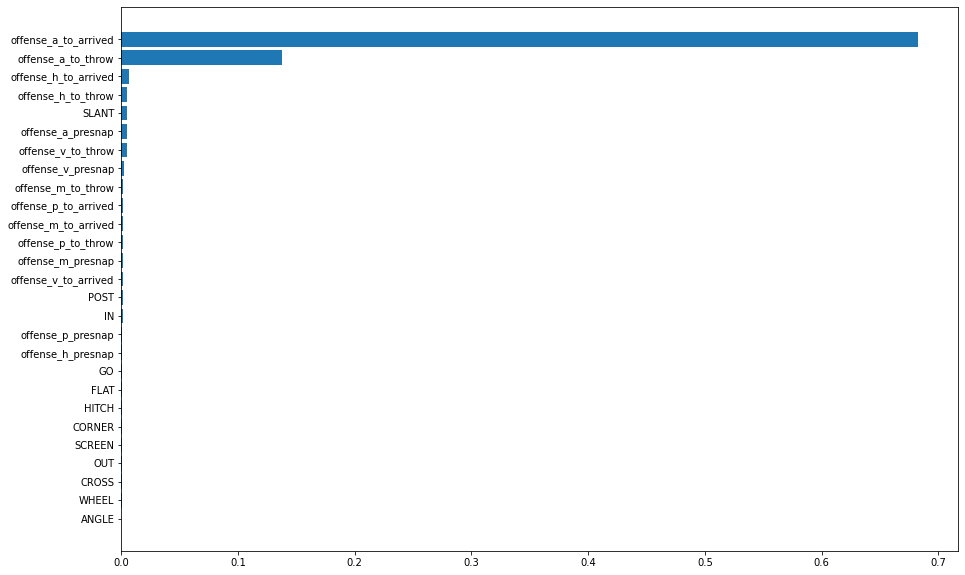

In [79]:
plt.figure(figsize=(15, 10))
sorted_idx_a = perm_imp_a.importances_mean.argsort()
plt.barh(clf_a.feature_names_in_[sorted_idx_a], perm_imp_a.importances_mean[sorted_idx_a])

In [80]:
#TODO: Accuracy scoring test

In [81]:
predicted = clf_k.predict(x_test)
print(
    f'Classification report for classifier {clf_k}:\n'
    f'{metrics.classification_report(y_test["clusters_kmeans"], predicted)}\n'
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       641
           1       0.99      0.97      0.98       343
           2       1.00      0.73      0.85        82
           3       0.97      0.96      0.97       504
           4       0.91      0.99      0.95       278
           5       0.97      0.97      0.97       574

    accuracy                           0.96      2422
   macro avg       0.97      0.93      0.95      2422
weighted avg       0.97      0.96      0.96      2422




Confusion Matrix:
[[626   0   0   9   0   6]
 [  0 333   0   0   0  10]
 [  0   0  60   0  22   0]
 [ 15   0   0 485   4   0]
 [  0   0   0   4 274   0]
 [ 12   3   0   0   0 559]]


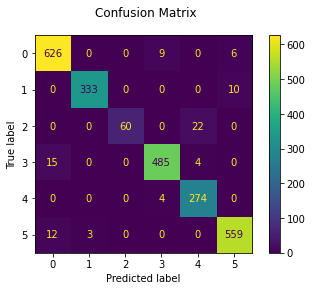

In [82]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test['clusters_kmeans'], predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

In [83]:
predicted = clf_a.predict(x_test)
print(
    f'Classification report for classifier {clf_a}:\n'
    f'{metrics.classification_report(y_test["clusters_agg"], predicted)}\n'
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       556
           1       1.00      0.74      0.85        81
           2       0.93      0.93      0.93       384
           3       0.96      0.96      0.96       693
           4       0.94      0.96      0.95       535
           5       0.86      0.90      0.88       173

    accuracy                           0.95      2422
   macro avg       0.94      0.91      0.92      2422
weighted avg       0.95      0.95      0.95      2422




Confusion Matrix:
[[542   0   0   0  14   0]
 [  0  60   2   0   0  19]
 [  0   0 358  20   0   6]
 [  0   0   9 666  18   0]
 [ 12   0   0  11 512   0]
 [  0   0  18   0   0 155]]


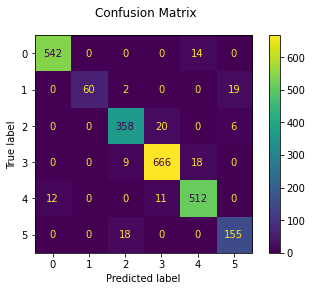

In [84]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test['clusters_agg'], predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

[1e-06, 8.944444444444444e-07, 7.888888888888889e-07, 6.833333333333333e-07, 5.777777777777778e-07, 4.722222222222222e-07, 3.666666666666666e-07, 2.6111111111111113e-07, 1.5555555555555554e-07, 5e-08]


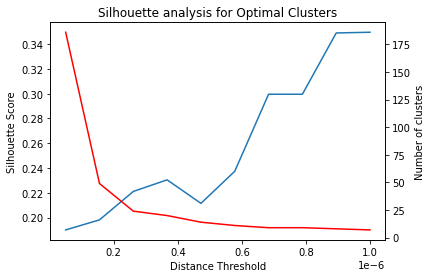

In [85]:
range_limit = []
[range_limit.append(n) for n in np.linspace(1*10**-6, 5*10**-8, 10)]
print(range_limit)
silhouette_avg = []
n_clusters = []
for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    n_clusters.append(len(np.unique(model.labels_)))

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_limit, silhouette_avg)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
ax2 = ax.twinx()
ax2.plot(range_limit, n_clusters, color='r')
ax2.set_ylabel('Number of clusters')
plt.show()

In [28]:
agglom_sizes = df.groupby('clusters_agg').size()
agglom_sizes

clusters_agg
0    1449
1     183
2     905
3    1736
4    1328
5     452
dtype: int64

In [29]:
df.head()

,gameId,playId,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_p_presnap,offense_p_to_throw,offense_p_to_arrived,offense_m_presnap,offense_m_to_throw,...,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes,clusters_kmeans,clusters_agg
0,2018090600,75,-0.000000,4.733452,4.306341,0.491735,0.586294,0.488032,0.455213,0.265324,...,0,0,0,0,0,0,0,4,5,4
1,2018090600,146,0.722081,4.249899,3.185872,0.466888,0.413593,0.501455,0.352721,0.198450,...,0,0,0,0,0,0,0,5,1,0
3,2018090600,190,-0.000000,5.278721,4.789590,0.368274,0.272067,0.305495,0.325148,0.405869,...,0,0,1,1,0,0,0,3,5,4
4,2018090600,256,0.592412,3.949740,4.065981,0.521001,0.355874,0.586696,0.222165,0.272859,...,0,0,0,0,0,0,0,3,1,4
5,2018090600,320,0.856801,4.486656,4.609067,0.203906,0.588602,0.382720,0.103318,0.213341,...,0,0,0,0,1,0,0,5,1,0


In [30]:
df.groupby('clusters_agg')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

clusters_agg,0,1,2,3,4,5
HITCH,0.500345,0.486339,0.845304,0.814516,0.738705,0.670354
OUT,0.340925,0.562842,0.476243,0.505760,0.478916,0.506637
FLAT,0.848861,0.792350,0.566851,0.604263,0.648343,0.685841
CROSS,0.303658,0.415301,0.348066,0.443548,0.432982,0.404867
GO,0.712905,1.196721,1.049724,0.879032,0.795181,1.081858
SLANT,0.654244,0.032787,0.077348,0.164171,0.480422,0.042035
SCREEN,0.492754,0.092896,0.121547,0.138825,0.164910,0.121681
CORNER,0.076605,0.213115,0.172376,0.170507,0.137801,0.219027
IN,0.126984,0.180328,0.427624,0.431452,0.319277,0.314159
ANGLE,0.199448,0.147541,0.206630,0.165899,0.139307,0.190265


In [31]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

gameId,2018090600,2018090900,2018090901,2018090902,2018090903,2018090905,2018090906,2018090907,2018090909,2018090910,...,2018123006,2018123007,2018123008,2018123009,2018123010,2018123011,2018123012,2018123013,2018123014,2018123015
HITCH,0.921569,0.75,0.48,0.65,0.709677,0.75,0.533333,0.35,0.95,0.842105,...,1.000000,0.222222,1.071429,0.70,0.857143,0.80,0.76,0.500000,0.727273,0.590909
OUT,0.333333,0.35,0.32,0.45,0.580645,0.50,0.333333,0.55,0.50,0.578947,...,0.142857,0.611111,0.642857,0.70,0.500000,0.44,0.44,0.611111,0.545455,0.772727
FLAT,0.803922,0.70,0.68,0.65,0.645161,0.55,0.666667,0.60,1.15,0.526316,...,0.500000,0.500000,0.750000,0.30,0.535714,0.88,0.72,0.500000,0.590909,0.363636
CROSS,0.450980,0.25,0.40,0.35,0.419355,0.25,0.133333,0.25,0.30,0.526316,...,0.142857,0.666667,0.285714,0.35,0.428571,0.44,0.76,0.277778,0.590909,0.409091
GO,0.823529,0.90,1.16,1.00,0.870968,1.00,0.800000,0.80,0.60,0.578947,...,0.642857,0.777778,0.857143,1.10,0.714286,0.84,0.48,0.611111,0.818182,0.590909
SLANT,0.156863,0.30,0.28,0.25,0.225806,0.40,0.400000,0.30,0.35,0.315789,...,0.857143,0.333333,0.428571,0.20,0.107143,0.20,0.28,0.222222,0.227273,0.181818
SCREEN,0.078431,0.10,0.56,0.35,0.161290,0.15,0.333333,0.25,0.20,0.263158,...,0.285714,0.388889,0.178571,0.55,0.464286,0.20,0.16,0.166667,0.227273,0.272727
CORNER,0.196078,0.15,0.12,0.00,0.129032,0.10,0.266667,0.25,0.35,0.105263,...,0.285714,0.111111,0.107143,0.00,0.321429,0.12,0.16,0.388889,0.136364,0.090909
IN,0.450980,0.40,0.32,0.20,0.419355,0.55,0.466667,0.30,0.25,0.421053,...,0.142857,0.222222,0.321429,0.45,0.178571,0.36,0.44,0.555556,0.136364,0.454545
ANGLE,0.137255,0.20,0.16,0.20,0.322581,0.10,0.333333,0.15,0.10,0.157895,...,0.071429,0.166667,0.071429,0.20,0.250000,0.04,0.04,0.277778,0.136364,0.181818


<AxesSubplot:title={'center':'Average routes per play per game'}, ylabel='Number per play'>

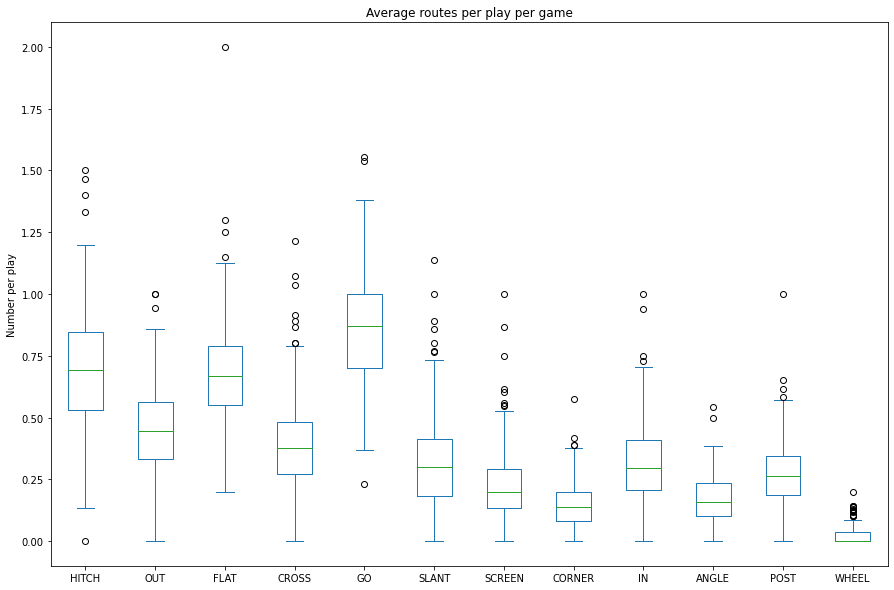

In [32]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box(figsize=(15,10), xlabel='Route', ylabel='Number per play', title='Average routes per play per game')

<AxesSubplot:title={'center':'Average routes per play per cluster'}, ylabel='Number per play'>

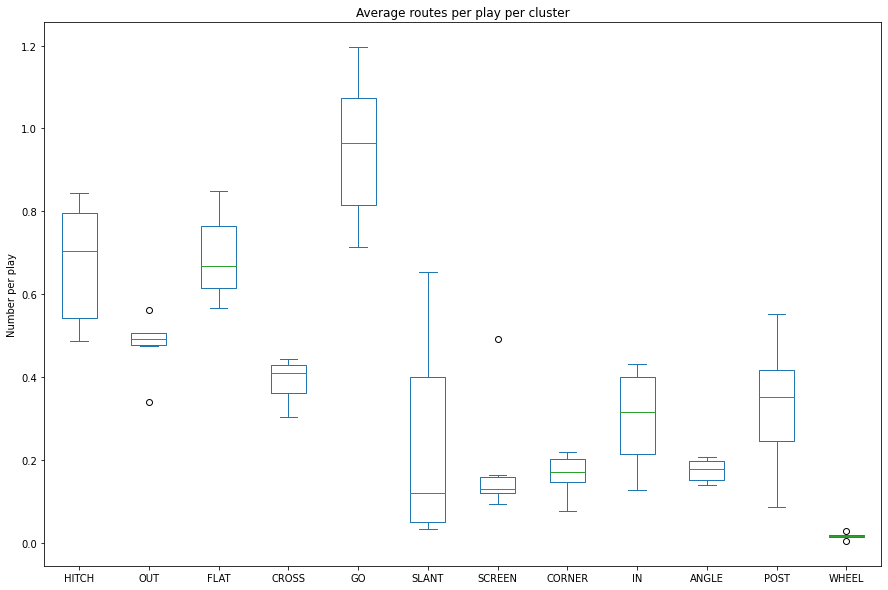

In [33]:
df.groupby('clusters_agg')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box(figsize=(15,10), xlabel='Route', ylabel='Number per play', title='Average routes per play per cluster')

In [34]:
cluster0 = df.drop(['gameId', 'playId', 'clusters_agg'], axis=1).loc[(df['clusters_agg'] == 0)]
cluster0.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.29379
offense_h_to_throw        4.13736
offense_h_to_arrived      3.78622
offense_p_presnap         0.40520
offense_p_to_throw        0.48055
offense_p_to_arrived      0.47676
offense_m_presnap         0.26374
offense_m_to_throw        0.28075
offense_m_to_arrived      0.33641
offense_v_presnap         0.05089
offense_v_to_throw        0.45582
offense_v_to_arrived      0.75745
offense_a_presnap        64.02868
offense_a_to_throw       89.99921
offense_a_to_arrived    172.50588
HITCH                     0.50035
OUT                       0.34092
FLAT                      0.84886
CROSS                     0.30366
GO                        0.71291
SLANT                     0.65424
SCREEN                    0.49275
CORNER                    0.07660
IN                        0.12698
ANGLE                     0.19945
POST                      0.08696
WHEEL                     0.01863
num_routes                4.36232
clusters_kmeans           3.36439
dtype: object

In [35]:
cluster2 = df.drop(['gameId', 'playId', 'clusters_agg'], axis=1).loc[(df['clusters_agg'] == 2)]
cluster2.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.15865
offense_h_to_throw        4.96525
offense_h_to_arrived      4.06966
offense_p_presnap         0.43430
offense_p_to_throw        0.51577
offense_p_to_arrived      0.53080
offense_m_presnap         0.25085
offense_m_to_throw        0.30032
offense_m_to_arrived      0.29471
offense_v_presnap         0.03048
offense_v_to_throw        0.76059
offense_v_to_arrived      0.92668
offense_a_presnap        73.84085
offense_a_to_throw      193.80047
offense_a_to_arrived    474.52385
HITCH                     0.84530
OUT                       0.47624
FLAT                      0.56685
CROSS                     0.34807
GO                        1.04972
SLANT                     0.07735
SCREEN                    0.12155
CORNER                    0.17238
IN                        0.42762
ANGLE                     0.20663
POST                      0.37348
WHEEL                     0.01326
num_routes                4.67845
clusters_kmeans           0.92818
dtype: object

In [36]:
cluster0.columns

Index(['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes', 'clusters_kmeans'],
      dtype='object')

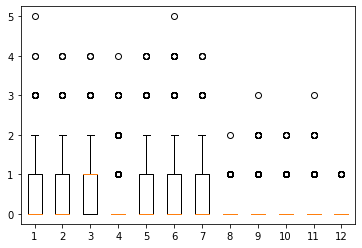

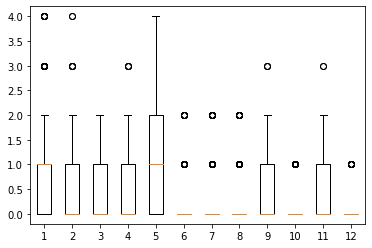

In [37]:
plt.boxplot(cluster0[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()
plt.boxplot(cluster2[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()

In [38]:
verticals = df.loc[(df['GO'] == 4)]
sorted(verticals['clusters_agg'].unique().tolist())

[0, 1, 2, 3, 4, 5]

In [39]:
flood = df.loc[(df['CORNER'] == 1) & (df['OUT'] == 1) & (df['FLAT'] == 1) & (df['POST'] == 1)]
sorted(flood['clusters_agg'].unique().tolist())

[1, 2, 3, 4, 5]

In [40]:
slants = df.loc[(df['SLANT'] >= 2)]
sorted(slants['clusters_agg'].unique().tolist())

[0, 2, 3, 4, 5]

In [86]:
def plot_relationship(df, xcol, ycol, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    main_ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        left=True,
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    x = df[xcol]
    y = df[ycol]
    main_ax.scatter(x, y, c=labels)

    x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
    x_hist.invert_yaxis()
    x_hist.set_xlabel(xcol)

    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
    y_hist.invert_xaxis()
    y_hist.set_ylabel(ycol)

In [87]:
df_columns = df.drop(['gameId', 'playId', 'clusters_agg', 'clusters_kmeans', 'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL'], axis=1).columns.tolist()
#for subset in combinations(df_columns, 2):
    #plot_relationship(df, subset[0], subset[1], df['clusters_kmeans'])

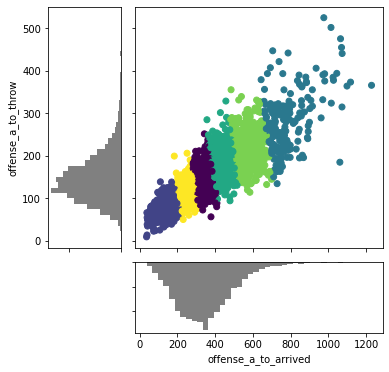

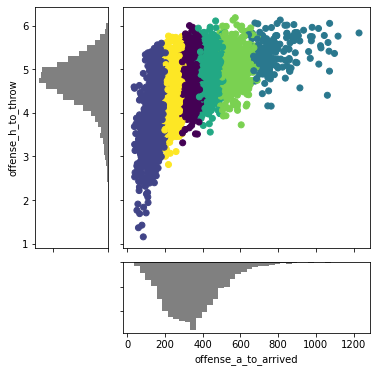

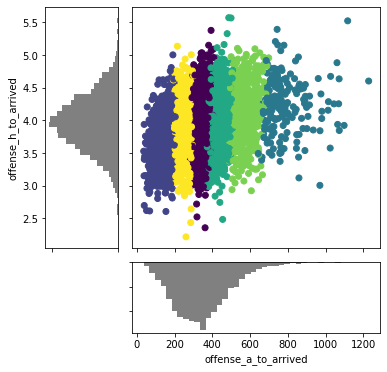

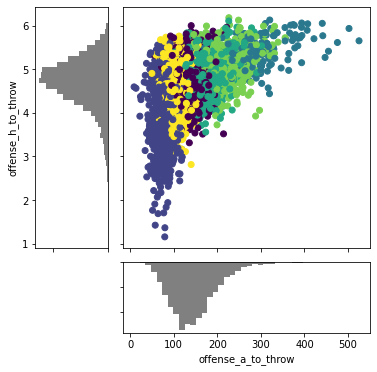

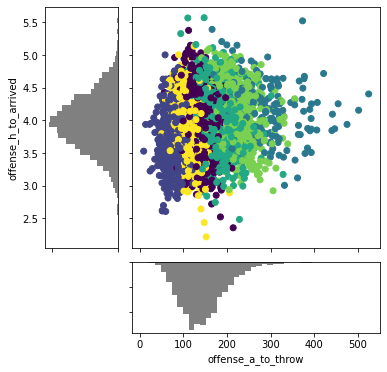

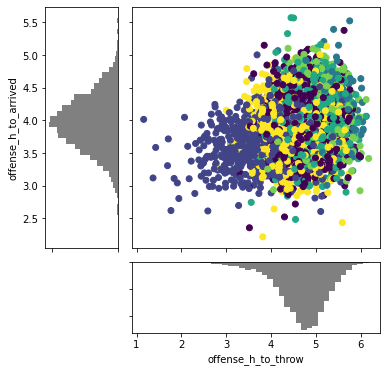

In [88]:
df_columns = df_scaled[['offense_a_to_arrived', 'offense_a_to_throw', 'offense_h_to_throw', 'offense_h_to_arrived']].columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], df['clusters_kmeans'])

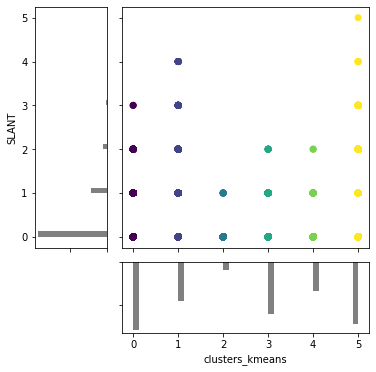

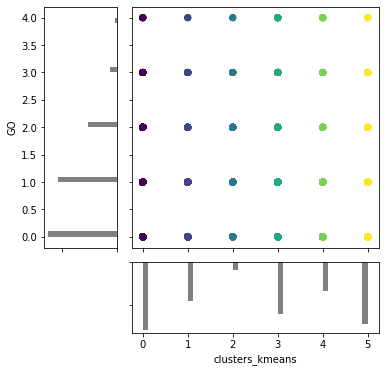

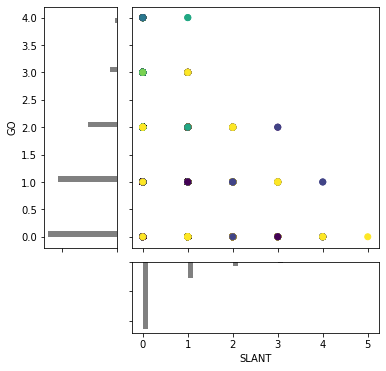

In [89]:
df_columns = df[['clusters_kmeans', 'SLANT', 'GO']].columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], df['clusters_kmeans'])

In [90]:
from mpl_toolkits import mplot3d
#%matplotlib notebook

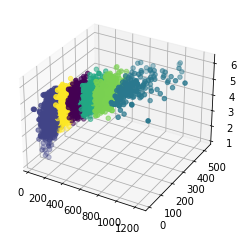

In [91]:
ax = plt.axes(projection='3d')
x = df['offense_a_to_arrived']
y = df['offense_a_to_throw']
z = df['offense_h_to_throw']
ax.scatter3D(x, y, z, c=df['clusters_kmeans'])

## Visualisation of order parameters within clusters

In [99]:
def draw_prob_density(x_series, y_series, x_bins, y_bins, ax, xlab=None, ylab=None, cbar=True):
    dims = {'x': x_series.max() * 1.00001, 'y': y_series.max() * 1.00001}

    bins = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    rows = min(len(y_series), len(x_series))

    for row in range(rows):
        i = int(x_series.iloc[row] / dims['x'] * x_bins)
        j = int(y_series.iloc[row] / dims['y'] * y_bins)
        bins[j][i] += 1

    smoothing_grid = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    for i in range(x_bins):
        for j in range(y_bins):
            sum = 0
            count = 0
            for x in range(-1, 2):
                for y in range(-1, 2):
                    if 0 <= i + x < x_bins and 0 <= j + y < y_bins:
                        sum += bins[j + y][i + x]
                        count += 1
            smoothing_grid[j][i] = sum / count

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if cbar:
        c = ax.pcolor(smoothing_grid, cmap='jet')
        plt.colorbar(c, ax=ax)
    else:
        ax.pcolor(smoothing_grid, cmap='jet')

In [100]:
fig_height = 3

In [103]:
df_clustered = play_df[['gameId', 'playId', 'offense_p_play', 'offense_m_play', 'offense_v_play', 'offense_a_play','offense_h_play', 'offense_h_presnap',
              'offense_h_to_throw', 'offense_h_to_arrived',
              'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
              'offense_m_presnap',
              'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
              'offense_v_to_arrived',
              'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
              'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
              'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']].dropna().copy()

df_clustered['cluster'] = km.fit_predict(normalize(df_clustered))
df_clustered['cluster'] = y_km

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

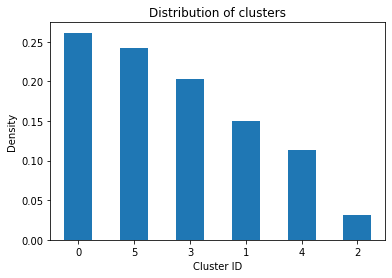

In [104]:
(df_clustered['cluster'].value_counts() / df_clustered['cluster'].value_counts().sum()).plot.bar(rot=0,
                                                                                             title='Distribution of clusters',
                                                                                             xlabel='Cluster ID',
                                                                                             ylabel='Density')

In [105]:
clusters = df_clustered['cluster'].max()

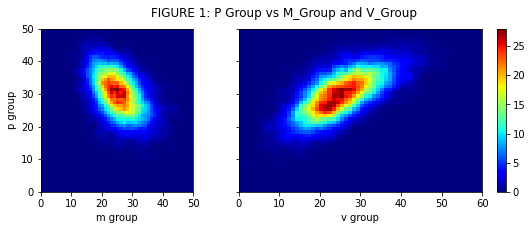

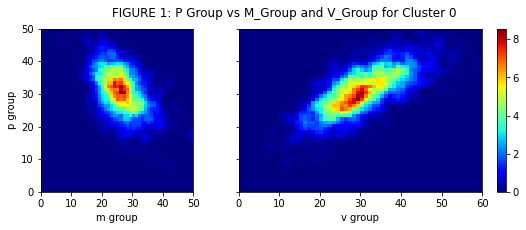

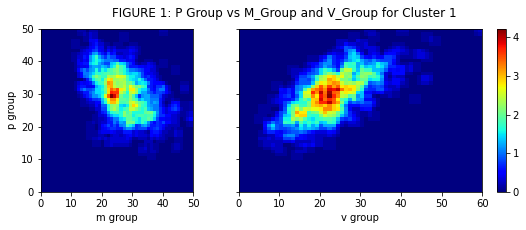

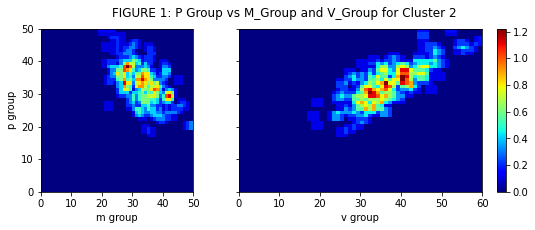

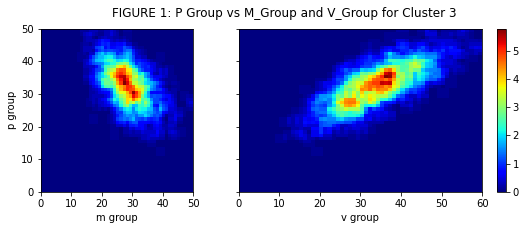

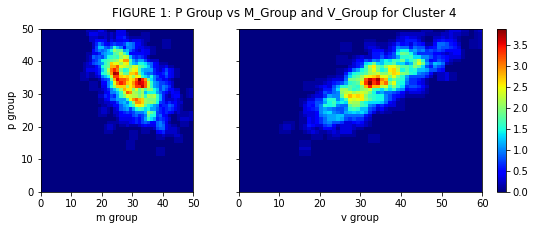

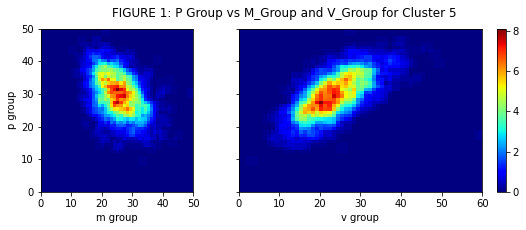

In [106]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                        gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(df_clustered['offense_m_play'], df_clustered['offense_p_play'], 50, 50, axs[0], xlab='m group', ylab='p group', cbar=False)
draw_prob_density(df_clustered['offense_v_play'], df_clustered['offense_p_play'], 60, 50, axs[1], xlab='v group')

fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group')

for cluster in range(clusters + 1):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                            gridspec_kw={'width_ratios': [1, 2]})

    cluster_df = df_clustered[df_clustered['cluster'] == cluster]

    draw_prob_density(cluster_df['offense_m_play'], cluster_df['offense_p_play'], 50, 50, axs[0], xlab='m group', ylab='p group', cbar=False)
    draw_prob_density(cluster_df['offense_v_play'], cluster_df['offense_p_play'], 60, 50, axs[1], xlab='v group')

    fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group for Cluster {cluster}')

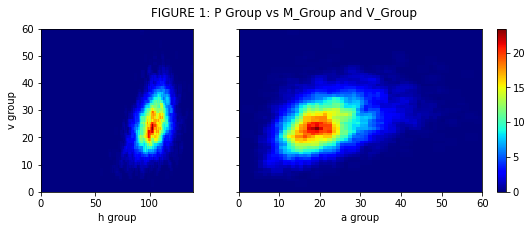

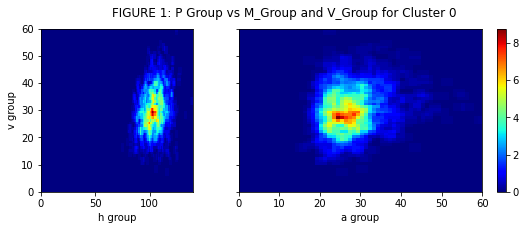

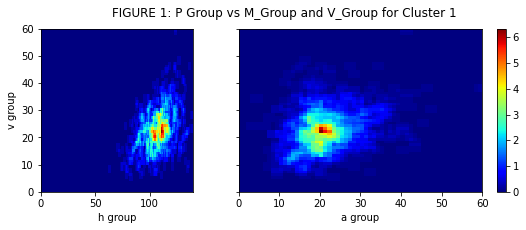

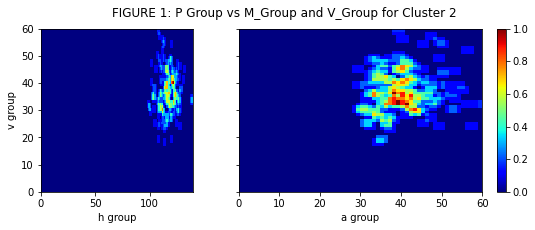

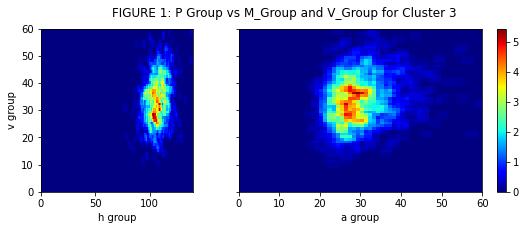

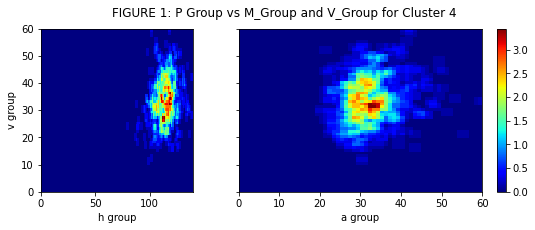

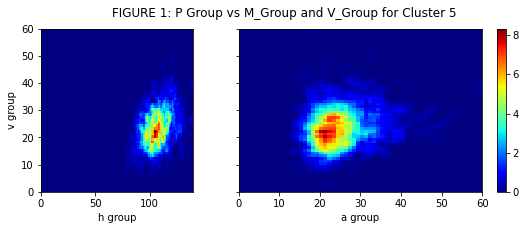

In [107]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                        gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(df_clustered['offense_h_play'], df_clustered['offense_v_play'], 140, 60, axs[0], xlab='h group', ylab='v group', cbar=False)
draw_prob_density(df_clustered['offense_a_play'], df_clustered['offense_v_play'], 60, 60, axs[1], xlab='a group')

fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group')

for cluster in range(clusters + 1):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                            gridspec_kw={'width_ratios': [1, 2]})

    cluster_df = df_clustered[df_clustered['cluster'] == cluster]

    draw_prob_density(cluster_df['offense_h_play'], cluster_df['offense_v_play'], 140, 60, axs[0], xlab='h group', ylab='v group', cbar=False)
    draw_prob_density(cluster_df['offense_a_play'], cluster_df['offense_v_play'], 60, 60, axs[1], xlab='a group')

    fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group for Cluster {cluster}')

In [126]:
from scipy.stats import ttest_ind

In [127]:
routes = ['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']
p_target = 0.02

route_sig = {'HITCH': 0, 'OUT': 0, 'FLAT': 0, 'CROSS': 0, 'GO': 0, 'SLANT': 0, 'SCREEN': 0, 'CORNER': 0,
       'IN': 0, 'ANGLE': 0, 'POST': 0, 'WHEEL': 0}
grid_dim = clusters + 1
differences = np.zeros(grid_dim ** 2).reshape(grid_dim, grid_dim)

for i in range(clusters + 1):
    for j in range(clusters + 1):
        if not j <= i:
            for route in routes:
                c1 = df_clustered.loc[df_clustered['cluster'] == i][route]
                c2 = df_clustered.loc[df_clustered['cluster'] == j][route]
                p_value = ttest_ind(c1, c2)[1]
                if p_value <= p_target:
                    differences[i][j] += 1
                    route_sig[route] += 1
                    print(f'P-Value for difference between clusters {i} and {j} for the {route} route: {p_value:.4f}')

P-Value for difference between clusters 0 and 1 for the HITCH route: 0.0000
P-Value for difference between clusters 0 and 1 for the OUT route: 0.0000
P-Value for difference between clusters 0 and 1 for the FLAT route: 0.0000
P-Value for difference between clusters 0 and 1 for the CROSS route: 0.0000
P-Value for difference between clusters 0 and 1 for the GO route: 0.0008
P-Value for difference between clusters 0 and 1 for the SLANT route: 0.0000
P-Value for difference between clusters 0 and 1 for the SCREEN route: 0.0000
P-Value for difference between clusters 0 and 1 for the CORNER route: 0.0000
P-Value for difference between clusters 0 and 1 for the IN route: 0.0000
P-Value for difference between clusters 0 and 1 for the ANGLE route: 0.0000
P-Value for difference between clusters 0 and 1 for the POST route: 0.0000
P-Value for difference between clusters 0 and 2 for the HITCH route: 0.0000
P-Value for difference between clusters 0 and 2 for the FLAT route: 0.0001
P-Value for differenc

<BarContainer object of 12 artists>

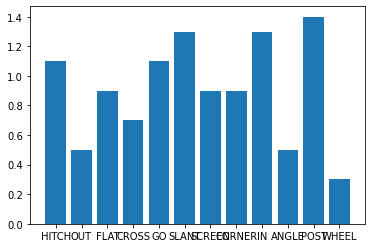

In [128]:
x = route_sig.keys()
y = list(route_sig.values())
plt.bar(x, ( y / ((clusters ** 2 - clusters) / 2)))

In [129]:
differences[:, :]

array([[ 0., 11.,  6.,  5.,  7.,  8.],
       [ 0.,  0.,  8., 10., 11., 10.],
       [ 0.,  0.,  0.,  5.,  4.,  6.],
       [ 0.,  0.,  0.,  0.,  3.,  8.],
       [ 0.,  0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [116]:
df_clustered.loc[df_clustered['cluster'] == 0]['HITCH'].mean()

0.8337547408343868

In [117]:
df_clustered.loc[df_clustered['cluster'] == 1]['HITCH'].mean()

0.40176600441501104

In [135]:
df_clustered.loc[df_clustered['cluster'] == 0][routes].mean()

HITCH     0.833755
OUT       0.484829
FLAT      0.595449
CROSS     0.460177
GO        0.845133
SLANT     0.234513
SCREEN    0.135904
CORNER    0.150442
IN        0.416561
ANGLE     0.155499
POST      0.305942
WHEEL     0.021492
dtype: float64

In [136]:
df_clustered.groupby('cluster')[routes].mean()

,HITCH,OUT,FLAT,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL
cluster,,,,,,,,,,,,
0,0.833755,0.484829,0.595449,0.460177,0.845133,0.234513,0.135904,0.150442,0.416561,0.155499,0.305942,0.021492
1,0.401766,0.283664,0.888521,0.269316,0.722958,0.626932,0.620309,0.060706,0.087196,0.227373,0.057395,0.012141
2,0.494681,0.553191,0.803191,0.409574,1.186170,0.031915,0.090426,0.207447,0.196809,0.159574,0.558511,0.010638
3,0.816476,0.492659,0.586460,0.365416,1.021207,0.090538,0.144372,0.161501,0.438825,0.198206,0.367863,0.018760
4,0.722384,0.515988,0.643895,0.398256,1.063953,0.043605,0.111919,0.229651,0.343023,0.170058,0.406977,0.007267
5,0.685578,0.467532,0.716336,0.401914,0.734108,0.601504,0.210526,0.133971,0.252905,0.150376,0.173616,0.028025


<AxesSubplot:>

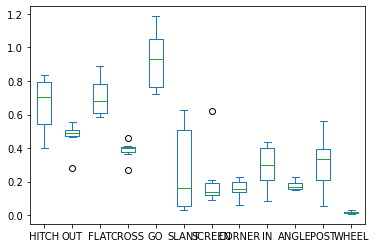

In [137]:
df_clustered.groupby('cluster')[routes].mean().plot.box()